In [1]:
#%%capture
#!pip install contextualized_topic_models

In [2]:
import pandas as pd    

result = pd.read_json(path_or_buf='questions.en.jsonl', lines=True)
result.head()

,id,text,topic
0,2,Do you think it is fundamentally right that th...,Welfare
1,4,"Should a 24-week period of ""parental leave"" be...",Welfare
2,6,The disability insurance system no longer prov...,Welfare
3,7,Would you support a national hospital planning...,Healthcare
4,9,Do you think it's right that certain forms of ...,Healthcare


In [3]:
result['topic'].unique()

array(['Welfare', 'Healthcare', 'Education', 'Immigration', 'Society',
       'Security', 'Finances', 'Economy', 'Foreign Policy',
       'Infrastructure & Environment', 'Political System', 'Digitisation'],
      dtype=object)

In [4]:
result = result.drop_duplicates(subset=['text'])
result

,id,text,topic
0,2,Do you think it is fundamentally right that th...,Welfare
1,4,"Should a 24-week period of ""parental leave"" be...",Welfare
2,6,The disability insurance system no longer prov...,Welfare
3,7,Would you support a national hospital planning...,Healthcare
4,9,Do you think it's right that certain forms of ...,Healthcare
...,...,...,...
189,3464,Do you support an expansion of the legal possi...,Security
190,3468,Should Switzerland start membership negotiatio...,Foreign Policy
191,3469,Should Switzerland strive for a free trade agr...,Foreign Policy
192,3470,An initiative calls for liability rules for Sw...,Foreign Policy


In [5]:
from contextualized_topic_models.models.ctm import ZeroShotTM, CombinedTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessingStopwords
import nltk
import torch
import random
import numpy as np

In [6]:
def fix_seeds():
    torch.manual_seed(10)
    torch.cuda.manual_seed(10)
    np.random.seed(10)
    random.seed(10)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.deterministic = True

## Preprocessing

In [7]:
from nltk.corpus import stopwords as stop_words
nltk.download('stopwords')
stopwords = list(set(stop_words.words('english')))

documents = result.text.tolist()
sp = WhiteSpacePreprocessingStopwords(documents, stopwords_list=stopwords)  # vocabulary_size, max_df, min_words, remove_numbers
preprocessed_documents, unpreprocessed_corpus, vocab = sp.preprocess()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cgarcia37/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
print('vocab-size',len(vocab))
vocab[:10]

vocab-size 863


['government',
 'council',
 'forms',
 'road',
 'record',
 'naturalization',
 'relaxation',
 'proved',
 'adjusted',
 'obtain']

In [9]:
preprocessed_documents[:5]


['think fundamentally right state financially support provision childcare working parents tax allowances subsidies',
 'week period parental leave introduced addition existing maternity insurance benefits',
 'disability insurance system longer provides disability benefits paid pain disorders cannot objectively proved result whiplash injury approve',
 'would support national hospital planning scheme even might lead closure hospitals',
 'think right certain forms alternative medicine reimbursed basic healthcare system']

In [10]:
unpreprocessed_corpus[:5]

['Do you think it is fundamentally right that the state should financially support the provision of childcare for working parents (through tax allowances or subsidies)?',
 'Should a 24-week period of "parental leave" be introduced in addition to the existing maternity insurance benefits?',
 'The disability insurance system no longer provides for disability benefits to be paid for pain disorders that cannot be objectively proved (e.g. as a result of whiplash injury). Do you approve?',
 'Would you support a national hospital planning scheme even if it might lead to the closure of hospitals?',
 "Do you think it's right that certain forms of alternative medicine are once again to be reimbursed under the basic healthcare system?"]

In [11]:
tp = TopicModelDataPreparation("paraphrase-distilroberta-base-v2")
training_dataset = tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#training_dataset.__dict__
#training_dataset.idx2token


## Training

In [12]:
fix_seeds() # uncomment if you don't want to fix the random seeds

num_topics = 12
ctm = CombinedTM(bow_size=len(tp.vocab), contextual_size=768, n_components=num_topics, num_epochs=80)   #lr,batch_size,hidden_sizes,dropout
#ctm = ZeroShotTM(bow_size=len(tp.vocab), contextual_size=768, n_components=num_topics, num_epochs=50)
ctm.fit(training_dataset) # run the model

Epoch: [80/80]	 Seen Samples: [13840/13840]	Train Loss: 70.48552231981576	Time: 0:00:01.963465: : 80it [02:38,  1.98s/it]
Sampling: [20/20]: : 20it [00:39,  1.96s/it]


## Postprocessing

In [13]:
import pyLDAvis as vis
vis.enable_notebook()
lda_vis_data = ctm.get_ldavis_data_format(tp.vocab, training_dataset, n_samples=10)

ctm_pd = vis.prepare(**lda_vis_data, R=20)
vis.display(ctm_pd)

Sampling: [10/10]: : 10it [00:19,  1.96s/it]


In [14]:
ctm.get_topic_lists(5)

[['tax', 'taxes', 'expanded', 'services', 'brokerage'],
 ['switzerland', 'fuels', 'fossil', 'co', 'extended'],
 ['chf', 'minimum', 'leave', 'wage', 'full'],
 ['zones', 'learning', 'focused', 'according', 'lehrplan'],
 ['refugees', 'united', 'accept', 'countries', 'law'],
 ['cantons', 'weak', 'contributions', 'women', 'equalisation'],
 ['well', 'consumption', 'possession', 'personal', 'use'],
 ['schools', 'animals', 'agriculture', 'plants', 'subjects'],
 ['openly', 'political', 'telephone', 'given', 'preventative'],
 ['eu', 'agreement', 'usa', 'trade', 'negotiations'],
 ['government', 'support', 'federal', 'students', 'childcare'],
 ['human', 'companies', 'rights', 'standards', 'relaxed']]

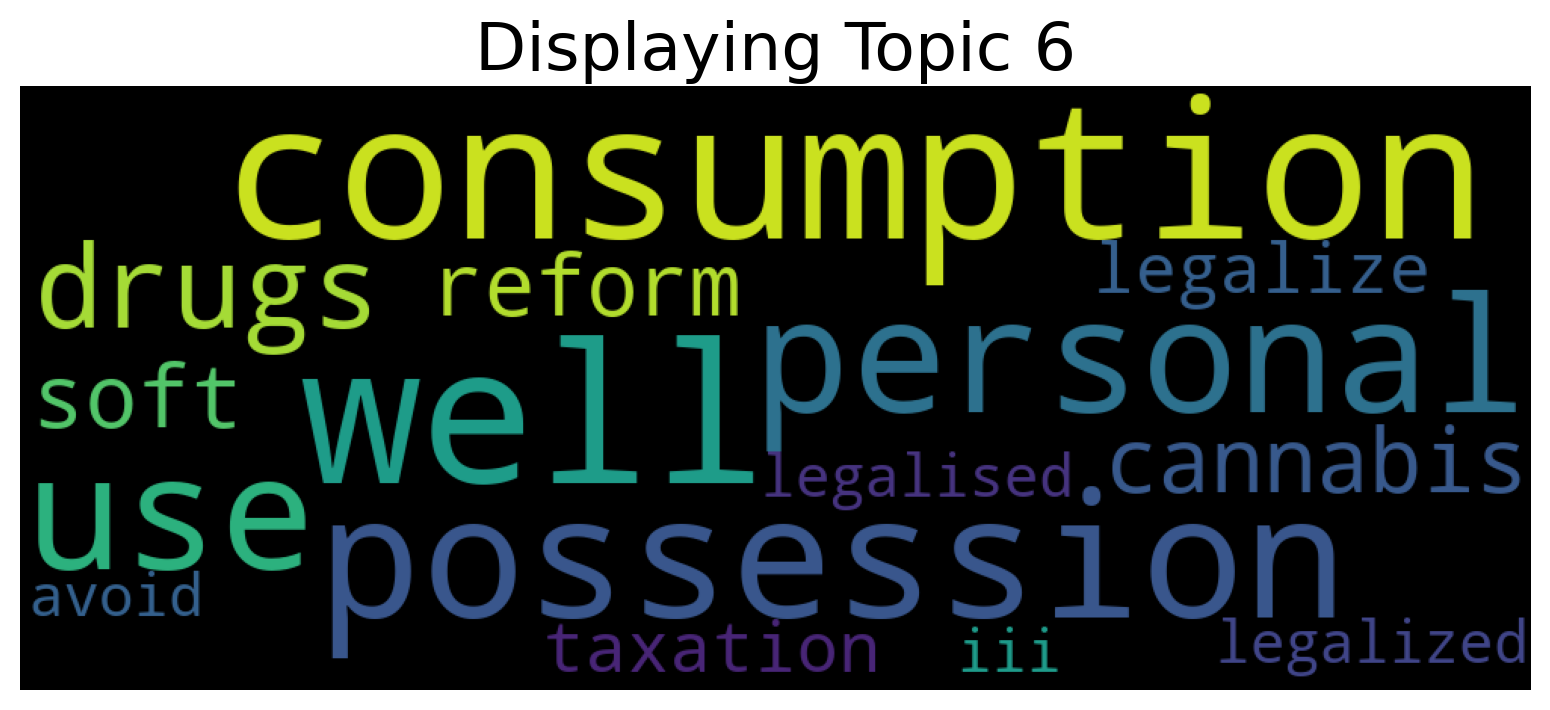

In [15]:
ctm.get_wordcloud(topic_id=6, n_words=15)

## Comparing with LDA

In [43]:
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import common_texts
from gensim.models import LdaModel 
from gensim.models.coherencemodel import CoherenceModel

split_preprocessed_documents = [d.split() for d in preprocessed_documents]
dictionary = Dictionary(split_preprocessed_documents)
corpus = [dictionary.doc2bow(text) for text in split_preprocessed_documents]

lda = LdaModel(corpus, num_topics=num_topics, iterations=500, random_state=42)

In [52]:
#dictionary.__dict__
#dictionary.token2id
#dictionary.id2token[0]
#corpus[:3]

In [53]:
# Human readable format of corpus (term-frequency)
#[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:3]]

In [54]:
def get_topics_lda(topk=10):
    topic_terms = []
    for i in range(num_topics):
        topic_words_list = []
        for word_tuple in lda.get_topic_terms(i, topk):
            topic_words_list.append(dictionary[word_tuple[0]])
        topic_terms.append(topic_words_list)
    return topic_terms

get_topics_lda(5)

[['service', 'favour', 'federal', 'years', 'future'],
 ['think', 'refugees', 'increased', 'vaccination', 'countries'],
 ['support', 'switzerland', 'favour', 'federal', 'approve'],
 ['favour', 'construction', 'individual', 'operations', 'switzerland'],
 ['support', 'would', 'switzerland', 'level', 'cantons'],
 ['support', 'favour', 'building', 'services', 'federal'],
 ['switzerland', 'relaxed', 'consumption', 'chf', 'drugs'],
 ['switzerland', 'years', 'foreign', 'welcome', 'benefits'],
 ['switzerland', 'would', 'charge', 'support', 'fuels'],
 ['swiss', 'support', 'initiative', 'federal', 'switzerland'],
 ['switzerland', 'support', 'insurance', 'benefits', 'swiss'],
 ['swiss', 'support', 'federal', 'zurich', 'geneva']]

## Topic Coherence

In [55]:
cm = CoherenceModel(model=lda, dictionary=dictionary, 
                    texts=split_preprocessed_documents, coherence='c_npmi') # 'c-v', 'c_npmi'
lda_coherence = cm.get_coherence()  # get coherence value
print("coherence score LDA:", lda_coherence)

coherence score LDA: -0.38652023652055956


In [56]:
from contextualized_topic_models.evaluation.measures import CoherenceNPMI, CoherenceCV, InvertedRBO
corpus = [d.split() for d in preprocessed_documents]
coh = CoherenceNPMI(ctm.get_topic_lists(10), corpus)
print("coherence score CTM:", coh.score())

coherence score CTM: -0.06604174767088732


## Diversity of the topics

In [57]:
irbo_lda = InvertedRBO(get_topics_lda(10))       #inverted ranked biased overlap
print("diversity score LDA:", irbo_lda.score())  #Topics with common words at different rankings are penalized less than topics sharing the same words at the highest ranks.

irbo_ctm = InvertedRBO(ctm.get_topic_lists(10))
print("diversity score CTM:", irbo_ctm.score())

diversity score LDA: 0.817167000141342
diversity score CTM: 1.0


## Topic Prediction per document

In [75]:
topics_predictions = ctm.training_doc_topic_distributions # get all the topic predictions

import numpy as np
train_doc_id = 1
topic_id = np.argmax(topics_predictions[train_doc_id]) # get the topic id of the  document
ctm.get_topic_lists(10)[topic_id] #  get the top words of the most likely topic for the considered document

['chf',
 'minimum',
 'leave',
 'wage',
 'full',
 'benefits',
 'insurance',
 'weeks',
 'paternity',
 'conversion']

In [76]:
unpreprocessed_corpus[train_doc_id]

'Should a 24-week period of "parental leave" be introduced in addition to the existing maternity insurance benefits?'

In [77]:
print("Original label:", result['topic'][train_doc_id])
print("Most likely topic:", ctm.get_topic_lists(10)[topic_id])

Original label: Welfare
Most likely topic: ['chf', 'minimum', 'leave', 'wage', 'full', 'benefits', 'insurance', 'weeks', 'paternity', 'conversion']


## Top K documents for a topic

In [61]:
topic_id = 1
print(ctm.get_topics()[topic_id])

['switzerland', 'fuels', 'fossil', 'co', 'extended', 'charge', 'petrol', 'currently', 'oil', 'motor']


In [78]:
ctm.get_top_documents_per_topic_id(unpreprocessed_corpus, ctm.training_doc_topic_distributions, topic_id, k=7) # probability corresponds to the conditional probability of the document to be assigned to the considered topic

[('Would you agree to an increase in the minimum deductible relating to the compulsory basic health insurance scheme (KVG) from CHF\xa0300 to CHF\xa0500?',
  0.8541774243116379),
 ('Would you appreciate the introduction of needs-based minimum benefits for families on low income on a national level?',
  0.8215473413467407),
 ('An initiative calls for the introduction of paid paternity leave for four weeks. Do you support this proposal?',
  0.796079957485199),
 ('Should a 24-week period of "parental leave" be introduced in addition to the existing maternity insurance benefits?',
  0.7766359061002731),
 ('Do you think that paid paternity leave of several weeks should be introduced in addition to existing maternity insurance benefits?',
  0.7757631123065949),
 ("Are you in favour of introducing a general minimum wage of CHF 4'000 for all employees for full-time employment?",
  0.7070030614733696),
 ("Are you in favour of introducing a general minimum wage to the amount of approx. CHF\xa04'

## Topic distribution on the overall corpus

In [63]:
labels = ['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 
          'topic_10', 'topic_11']        

In [64]:
topic_id = 4
print(ctm.get_topic_lists(10)[topic_id])
ctm.get_top_documents_per_topic_id(unpreprocessed_corpus, ctm.training_doc_topic_distributions, topic_id, k=5)

['refugees', 'united', 'accept', 'countries', 'law', 'unhcr', 'host', 'quota', 'groups', 'increased']


[('The United Nations High Commissioner for Refugees (UNHCR) is seeking host countries for groups of refugees known as "quota refugees". Should Switzerland accept more of these groups?',
  0.9633250504732132),
 ('Do you think Switzerland should accept an increased number of refugees directly from crisis regions for which the United Nations High Commissioner for Refugees (UNHCR) needs host countries (what is called quota refugees)?',
  0.9141671389341355),
 ('Today, the Swiss Army can take part in UN or OSCE peace-keeping missions abroad, armed for self-defence purposes. Do you approve?',
  0.6721246045082807),
 ('Are you in favor of further tightening the asylum law?',
  0.5179121598601342),
 ('Do you think the Army should undertake policing tasks within Switzerland (e.g. protecting embassies and consulates, carrying out border protection work, and policing major events like the World Economic Forum in Davos)?',
  0.4954922528937459)]

In [65]:
print(labels,"\n")

ctm.get_topic_lists(5)

['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11'] 



[['tax', 'taxes', 'expanded', 'services', 'brokerage'],
 ['switzerland', 'fuels', 'fossil', 'co', 'extended'],
 ['chf', 'minimum', 'leave', 'wage', 'full'],
 ['zones', 'learning', 'focused', 'according', 'lehrplan'],
 ['refugees', 'united', 'accept', 'countries', 'law'],
 ['cantons', 'weak', 'contributions', 'women', 'equalisation'],
 ['well', 'consumption', 'possession', 'personal', 'use'],
 ['schools', 'animals', 'agriculture', 'plants', 'subjects'],
 ['openly', 'political', 'telephone', 'given', 'preventative'],
 ['eu', 'agreement', 'usa', 'trade', 'negotiations'],
 ['government', 'support', 'federal', 'students', 'childcare'],
 ['human', 'companies', 'rights', 'standards', 'relaxed']]

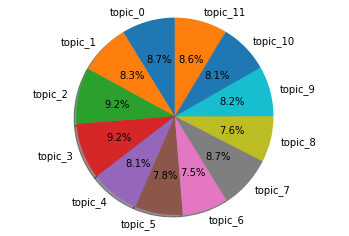

In [66]:
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
ax1.pie(np.average(ctm.training_doc_topic_distributions,axis=0),
        labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()